In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read data

In [2]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [3]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [4]:
df.count()

Date            1826
DayOfWeek       1826
DayOfWeekNum    1826
WeekOfYear      1826
Month           1826
IsWeekend       1826
IsHoliday       1826
temp_max        1826
temp_min        1826
temp_mean       1826
humidity_max    1826
humidity_min    1826
NUMBER_INT      1826
CO              1581
MP10            1457
O3              1265
MP2.5           1195
SO2             1091
dtype: int64

In [5]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    # 'Month',
    # 'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    # 'SO2',
    'temp_max',
    'temp_min',
    # 'temp_mean',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [6]:
# add lag
# df_final['SO2_lag1'] = df_final['SO2'].shift(1)
# df_final['SO2_lag2'] = df_final['SO2'].shift(2)
# df_final['SO2_lag3'] = df_final['SO2'].shift(3)

# df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
# df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [7]:
df_final = df_final.dropna()

In [8]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1823 entries, 3 to 1825
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1823 non-null   object 
 1   DayOfWeekNum   1823 non-null   int64  
 2   WeekOfYear     1823 non-null   int64  
 3   IsHoliday      1823 non-null   int64  
 4   NUMBER_INT     1823 non-null   int64  
 5   temp_max       1823 non-null   float64
 6   temp_min       1823 non-null   float64
 7   humidity_max   1823 non-null   float64
 8   temp_min_lag3  1823 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 142.4+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1823,1823,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1823.0,NaN,NaN,NaN,2.998903,2.00192,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1823.0,NaN,NaN,NaN,26.657707,15.041553,1.0,14.0,27.0,40.0,53.0
IsHoliday,1823.0,NaN,NaN,NaN,0.024136,0.153514,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1823.0,NaN,NaN,NaN,47.806363,15.627747,11.0,37.0,47.0,59.0,94.0
temp_max,1823.0,NaN,NaN,NaN,28.306089,3.039403,17.8,26.3,28.5,30.4,37.7
temp_min,1823.0,NaN,NaN,NaN,17.786725,2.625516,7.3,16.1,18.4,19.7,24.1
humidity_max,1823.0,NaN,NaN,NaN,82.257817,9.232062,42.0,77.0,84.0,90.0,94.0
temp_min_lag3,1823.0,NaN,NaN,NaN,17.790071,2.627804,7.3,16.1,18.4,19.7,24.1


In [9]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
IsHoliday          int64
NUMBER_INT         int64
temp_max         float64
temp_min         float64
humidity_max     float64
temp_min_lag3    float64
dtype: object

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [11]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [12]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final = df_final.sort_values(by='Date')

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)

df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [13]:
df_train.head()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
3,6,1,0,20,30.6,22.2,81.0,20.6
4,0,2,0,51,30.8,20.8,79.0,21.0
5,1,2,0,23,29.5,20.5,79.0,20.2
6,2,2,0,43,28.0,19.9,78.0,22.2
7,3,2,0,49,30.4,19.7,74.0,20.8


In [14]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1456,3,52,0,60,24.8,18.8,92.0,18.5
1457,4,52,0,61,25.4,18.5,92.0,18.5
1458,5,52,0,30,27.5,17.7,92.0,18.6
1459,6,52,0,26,27.3,18.5,93.0,18.8
1460,0,1,0,61,25.9,19.2,92.0,18.5


In [15]:
df_val.head()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1461,1,1,1,44,27.9,19.2,92.0,17.7
1462,2,1,0,45,31.1,18.9,90.0,18.5
1463,3,1,0,28,30.7,20.4,88.0,19.2
1464,4,1,0,37,25.4,19.0,91.0,19.2
1465,5,1,0,36,30.1,18.6,91.0,18.9


In [16]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag3
1821,4,52,0,48,29.1,19.9,83.0,17.6
1822,5,52,0,39,28.6,19.7,88.0,17.4
1823,6,52,0,36,29.4,18.8,90.0,20.8
1824,0,1,0,41,29.3,18.1,84.0,19.9
1825,1,1,0,49,29.9,18.8,79.0,19.7


## Test (10x with cv)

In [17]:
results = []

In [18]:
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [19]:
for i in range(10):

    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.2f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })



Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 40, 'subsample': 0.8}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.56
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80, 'subsample': 0.8}
Best R

In [20]:
# Show results
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,118.992317,10.908360,8.188351,15.589598,16.564951,0.498678,0.787845,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555116
1,2,1,121.320572,11.014562,8.215580,15.570044,16.578549,0.488869,0.783413,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.555288
2,3,2,122.321342,11.059898,8.257089,15.675398,16.743136,0.484652,0.782179,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.555869
3,4,3,120.072456,10.957758,8.193280,15.552857,16.554468,0.494127,0.786136,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555691
4,5,4,119.728317,10.942044,8.188264,15.533000,16.526586,0.495577,0.786991,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556519
5,6,5,118.992317,10.908360,8.188351,15.589598,16.564951,0.498678,0.787845,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555116
6,7,6,120.546547,10.979369,8.180317,15.553481,16.606850,0.492130,0.785746,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555509
7,8,7,120.316139,10.968871,8.176545,15.569990,16.611115,0.493100,0.784381,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556917
8,9,8,120.350945,10.970458,8.211185,15.586568,16.600968,0.492954,0.786130,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556851
9,10,9,118.992317,10.908360,8.188351,15.589598,16.564951,0.498678,0.787845,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555116


In [21]:
## Aggregate Results
print(results_df.describe())

            run  random_state         MSE       RMSE        MAE       MAPE  \
count  10.00000      10.00000   10.000000  10.000000  10.000000  10.000000   
mean    5.50000       4.50000  120.163327  10.961804   8.198731  15.581013   
std     3.02765       3.02765    1.080789   0.049233   0.023894   0.038382   
min     1.00000       0.00000  118.992317  10.908360   8.176545  15.533000   
25%     3.25000       2.25000  119.176317  10.916781   8.188286  15.557608   
50%     5.50000       4.50000  120.194298  10.963315   8.188351  15.578306   
75%     7.75000       6.75000  120.497646  10.977141   8.206709  15.589598   
max    10.00000       9.00000  122.321342  11.059898   8.257089  15.675398   

           sMAPE         R2  Correlation  Best Cross-validated R-squared  
count  10.000000  10.000000    10.000000                       10.000000  
mean   16.591652   0.493744     0.785851                        0.555799  
std     0.059227   0.004553     0.001972                        0.000718

## Plots    

In [23]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 1 with RMSE = 10.91
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}


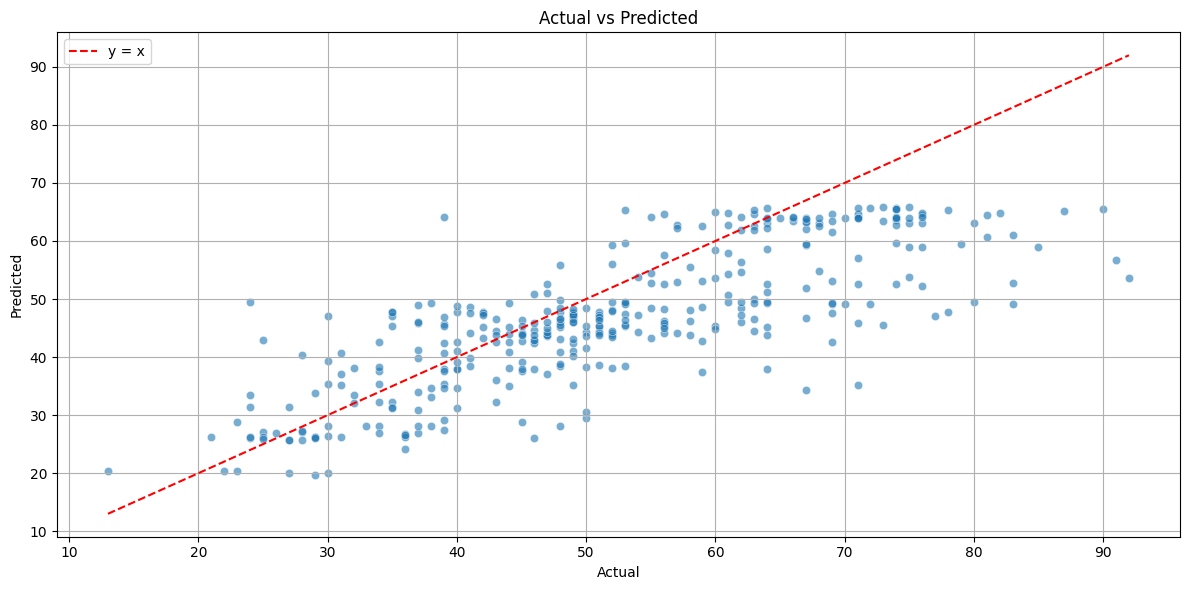

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val, y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

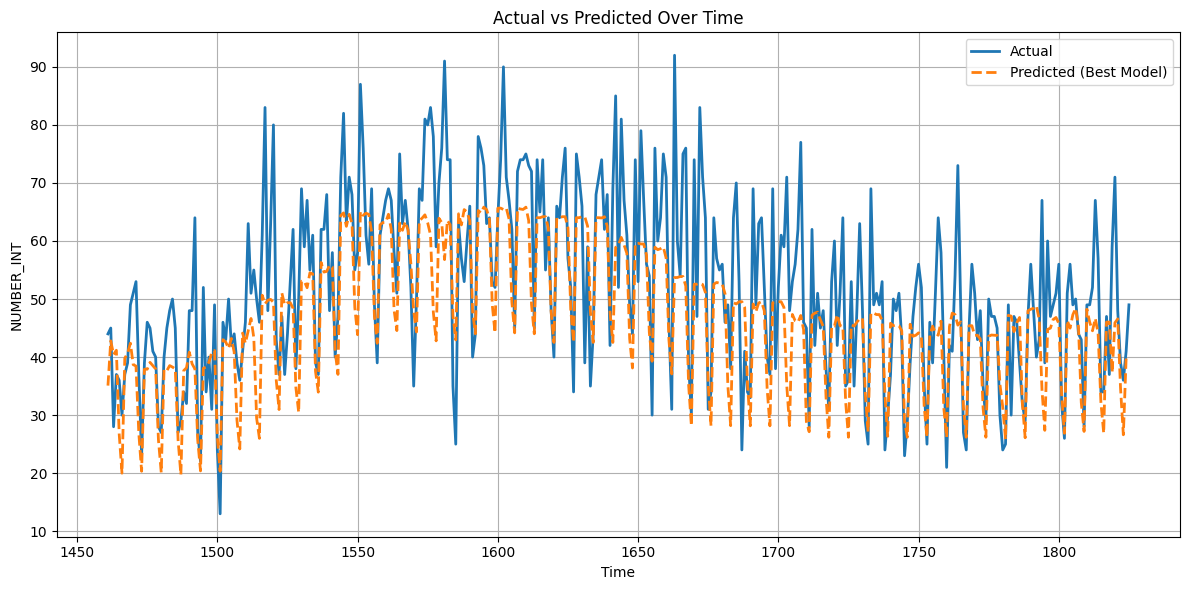

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

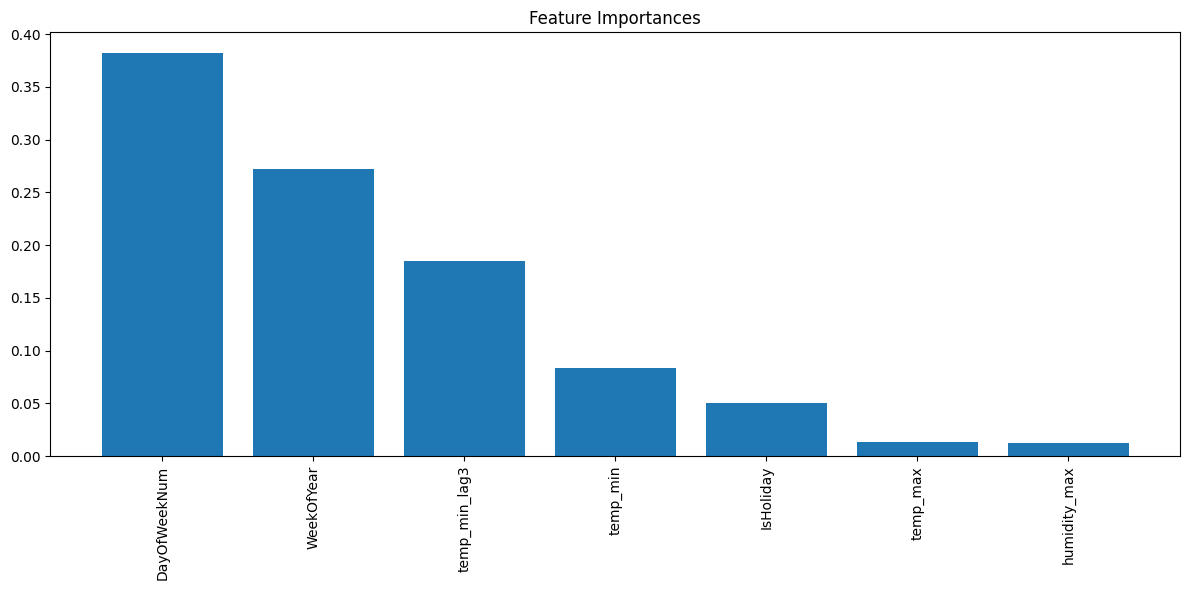

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()